Epoch:  0 Test-loss: 121.59542311557504 Train-Loss: 130.6863305513412


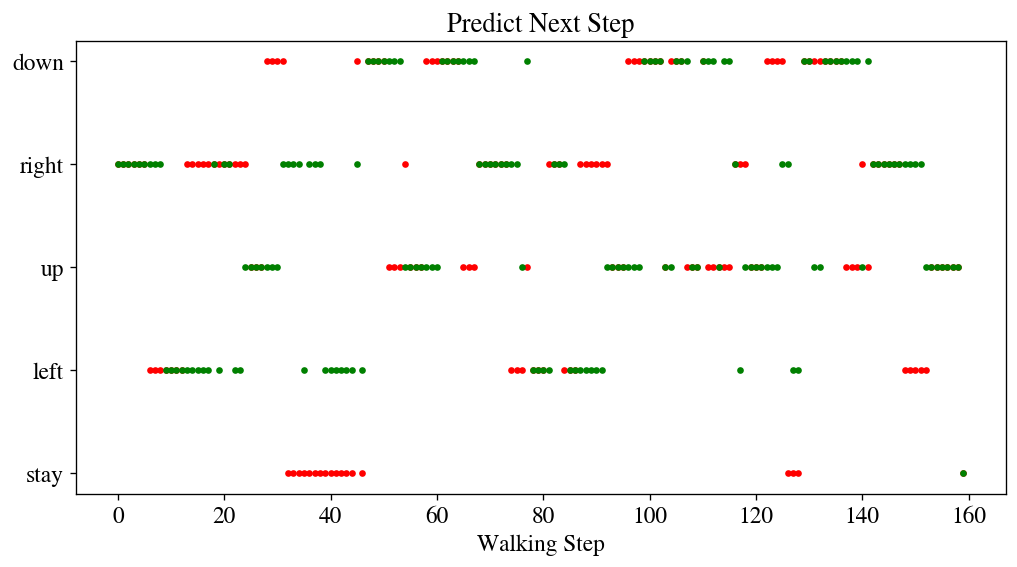

Epoch:  100 Test-loss: 120.76037411594156 Train-Loss: 129.85477326120835


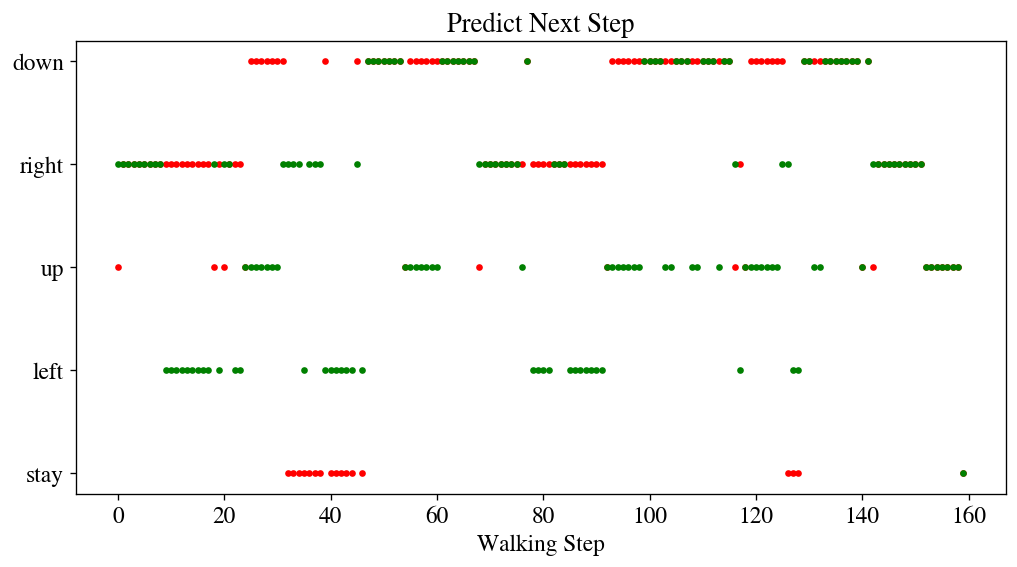

Epoch:  200 Test-loss: 120.46975643761988 Train-Loss: 129.5799354878794


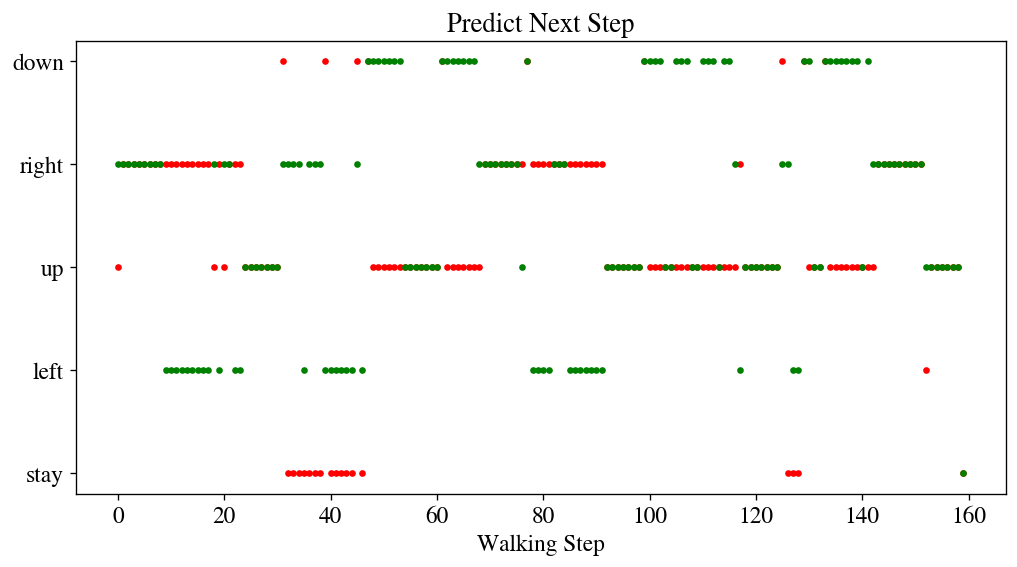

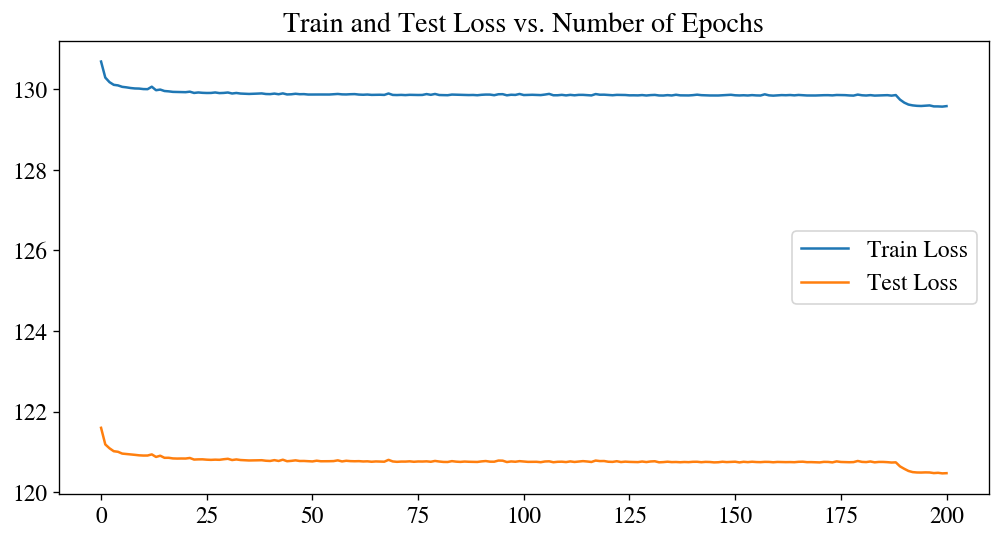

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.manual_seed(0)

from sklearn.model_selection import train_test_split
from utils import get_batch, sum_errors, draw, draw_train_test_errors
from generate_data import generate_dummy_dataset, directions


class LSTMTraveller(nn.Module):
    def __init__(self, input_dim, hidden_dim, target_size):
        super(LSTMTraveller, self).__init__()
        
        # The LSTM takes travels as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        
        # The linear layer maps from hidden state space to direction space
        self.hidden2direction = nn.Linear(hidden_dim, target_size)

    def forward(self, travel):
        lstm_out, _ = self.lstm(travel.view((travel.size(0), travel.size(1), travel.size(2))))
        linear_out = self.hidden2direction(lstm_out.view((travel.size(0), travel.size(1), lstm_out.size(2))))
        preds = F.softmax(linear_out, dim=2)
        return preds

def train(n_epochs=101, N_samples=100, hidden_dim=50, report=20):

    test_size = 0.125
    dataset = generate_dummy_dataset(N_samples=N_samples, 
                                     path='dataset.pkl', 
                                     S=None, 
                                     size=None)
    travels, targets, directions = dataset['travels'], dataset['targets'], dataset['directions'],

    #train_travels (samples), are not of the same length.
    #In order to have a batch_size > 1, you must make sure batches have the same length. This could be achieved by padding.
    batch_size = 1
    
    train_travels, test_travels, train_targets, test_targets = train_test_split(travels, 
                                                                                targets, 
                                                                                test_size=test_size, 
                                                                                shuffle=False)
    input_dim = len(train_travels[0][0])
    n_classes = len(directions)

    model = LSTMTraveller(input_dim=input_dim, 
                          hidden_dim=hidden_dim, 
                          target_size=n_classes).double()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                           lr=0.001)
    losses = torch.empty(size=(n_epochs, 2))
 
    for epoch in range(n_epochs):
        length = len(train_travels)
        permutation = torch.randperm(length)
        for i in range(0,length, batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = get_batch(train_travels, 
                                         train_targets, 
                                         indices, 
                                         n_classes)
            def closure():
                #For every mini-batch during the training phase, we want to set the gradients to zero before starting to do backpropragation since PyTorch accumulates the gradients on subsequent backward passes. 
                #It is convenient while training RNNs or when we want to compute the gradient of the loss summed over multiple mini-batches. 
                #So, the default action has been set to accumulate (i.e. sum) the gradients on every loss.backward() call.
                #Because of this, when we start the training loop, ideally we should zero out the gradients. 
                #Otherwise, the gradient would be a combination of the old gradient, which you have already used to update the model parameters, and the newly-computed gradient.
                optimizer.zero_grad()
                out = model(batch_x)
                loss = criterion(out, batch_y)
                loss.backward()
                return loss
            optimizer.step(closure)

        with torch.no_grad():
            test_loss, test_preds = sum_errors(test_travels, 
                                               test_targets, 
                                               criterion, 
                                               model, 
                                               n_classes)
            train_loss, _ = sum_errors(train_travels, 
                                       train_targets, 
                                       criterion,
                                       model, 
                                       n_classes)
            losses[epoch] = torch.Tensor([train_loss, test_loss])

        if epoch%report==0:
            print('Epoch: ', epoch, 'Test-loss:', test_loss, 'Train-Loss:', train_loss)
            #draw an example of predction vs. true directions taken in each step in the supermarket.
            draw(test_preds[0], test_targets[0], color1='r', color2='g')
    draw_train_test_errors(losses)


train(n_epochs=201, 
      N_samples=2000, 
      report=100)